#Task 1: Prepare your Jupyter Notebook

In [ ]:
module = "utils.py"
url = "https://cloud.tu-ilmenau.de/s/bdsqAywoLfca9e4/download"
!wget -nv -t 0 --show-progress -O $module $url

utils.py                [ <=>                ]   2.45K  --.-KB/s    in 0s      
2024-06-06 17:09:39 URL:https://cloud.tu-ilmenau.de/s/bdsqAywoLfca9e4/download [2507] -> "utils.py" [1]


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import utils

(train_ds, val_ds, test_ds), class_labels = utils.download_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
"""
Take 16 samples from the train dataset and plot them as images
along with their associated labels as provided in class_labels
"""
plt.figure(figsize = (10, 10))
samples = train_ds.take(16)

def get_image_and_label(samples):
  for image, label in samples:
      return image, label

for i in range(len(samples)):
  image, label = get_image_and_label(samples)
  plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(class_labels[label])
  plt.axis("off")
plt.show()

In [ ]:
# Helper function to check shape and label of the datatsets
def check_shape_and_label(dataset):
  for image, label in dataset.take(1):
    print(f"image:{image.shape}, \nlabel: {label}")

In [ ]:
"""
Write a preprocessing function to resize the images to a shape of (128, 128, 3).
"""
def resize_img(image, label, new_size=(128, 128)):
    image = tf.image.resize(image, new_size)  # Resize images to the new size
    return image, label

"""
At last, create a function named optimize_for_train(). The function shall take a dataset
as input and return a batched dataset allowing for efficient processing by
"""
def optimize_for_train(train_dataset, validation_datset, testing_dataset):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = validation_datset.cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds.batch(32), val_ds.batch(32), test_ds.batch(32)

In [ ]:
train_ds = train_ds.map(resize_img)
val_ds = val_ds.map(resize_img)
test_ds = test_ds.map(resize_img)

# Task 2: Small ConvNet

In [ ]:
from tensorflow.keras import layers, Model

#Initialize a ConvNet model using your build_convnet() function
def build_convnet(input_shape,
                  batch_size,
                  augment,
                  num_filters,
                  num_blocks,
                  size_filter
                  ):


  input_img = layers.Input(shape = input_shape, batch_size = batch_size)

  # Add a rescaling layer to the model to rescale the input images to a range of [0, 1].
  x = layers.Rescaling(scale = 1./255)(input_img)

  #Use optional augmentation layers to augment the input images. Add a boolean argument named augment to the function signature to control the augmentation.
  if augment:
    x = layers.RandomFlip()(x)
    x = layers.RandomRotation(factor = .1)(x)
    x = layers.RandomZoom(height_factor = .2)(x)
    x = layers.RandomContrast(factor = .2)(x)

  for i in range(num_blocks):
      #Convolution block
      # Each 2D convolutional layer shall use filters of size (size_filter, size_filter), linear activation, padding to maintain the input size, and a stride of 1.
      x = layers.Conv2D(filters = num_filters, kernel_size = (size_filter, size_filter), activation = "linear", padding = "same", use_bias=True, strides = (1,1))(x)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.MaxPool2D(pool_size=(2, 2))(x)
      num_filters *= 2

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(rate = .3)(x)
  outputs = layers.Dense(units = len(class_labels), activation = "softmax")(x)
  model = Model(inputs = input_img,
              outputs = outputs)

  return model

In [ ]:
my_convnet = build_convnet(input_shape=(128, 128, 3), batch_size = 32,
              augment=False, num_filters = 32, num_blocks = 4, size_filter = 3)
print(my_convnet.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 128, 128, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (32, 128, 128, 32)        128       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (32, 128, 128, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 64, 64, 32)          0         
 g2D)                                                      


##Discussion related to Convnet Architecture, Output Size, and Activation Function:
================================================================================================================
###`Importance of Bias Terms:`
#### Bias terms are really important because they allow the model to be more flexible in regards to uncertainty, bias terms allow the model to consider different possibilities of recognizing the same pattern. In the context of convolutional networks, each convolutional layer has a filter with its separate bias term, this bias term helps the model to have a range of possibilites to extract features such as edge detection in an image
================================================================================================================
###`Correct Output Size and Activation Function:`
#### The correct output size depends on the number of classes we are dealing with, for example, the dataset that we are using is Caltech101 which has a total of 101 + 1 Background Class = 102 Classes, so the output should be a probability that ranges between these 102 classes and when added must be equal to 1, as for the activation function, when we are dealing with multi-class classification problems we use the activation function called "Softmax", as it divides the probabilities of classes present in an image (in our context).

#Task 3: Experiments

In [ ]:
#TODO
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
"""
create a function called train_model() that trains your ConvNet model.
Given augment, num_blocks, num_filters, and size_filter the train_model() function shall
• Initialize a ConvNet model using your build_convnet() function.
• Compile the model using the Adam optimizer with a learning rate of 0.003, the
  sparse categorical crossentropy loss function, and the sparse categorical accuracy
  metric.
• Print the model summary.
• Reduce the learning rate by a factor of 0.2 if the validation loss does not improve
  for 30 epochs, check the ReduceLROnPlateau callback.
• Train the model for a maximum of 200 epochs and validate after each epoch.
• Stop the training if the validation loss does not improve for 60 epochs and return
  the best model.
• Return the trained model and history.
  Use the optimize_for_train() function to create batched datasets for the train, validation,
  and test data.
"""
def train_model(train, validation, input_shape=(128, 128, 3), batch_size = 32,
                augment=True, num_filters = 16, num_blocks = 2, size_filter = 3):
  """
  input_shape=(128, 128, 3), batch_size = 32, augment=True, num_filters = 16, num_blocks = 4, size_filter = 3
  """
  model = build_convnet(input_shape= input_shape, batch_size = batch_size,
                augment=augment, num_filters = num_filters, num_blocks = num_blocks, size_filter = size_filter)

  model.compile(
  optimizer=optimizers.Adam(learning_rate=1e-3),
  loss=losses.SparseCategoricalCrossentropy(),
  metrics=[
      metrics.SparseCategoricalAccuracy(),
  ],
  )

  print(model.summary())

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=30, min_lr=0.001,
                                 )
  early_stop = EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=60,
  )
  history = model.fit(train, validation_data=validation, callbacks=[reduce_lr, early_stop], epochs = 200,)

  return model, history

In [ ]:
batched_train, batched_val, batched_test = optimize_for_train(train_ds, val_ds, test_ds)

In [ ]:
print("Non-batched dataset:")
check_shape_and_label(train_ds)
check_shape_and_label(val_ds)
check_shape_and_label(test_ds)
print("Batched dataset:")
check_shape_and_label(batched_train)
check_shape_and_label(batched_val)
check_shape_and_label(batched_test)

Non-batched dataset:
image:(128, 128, 3), 
label: 91
image:(128, 128, 3), 
label: 95
image:(128, 128, 3), 
label: 28
Batched dataset:
image:(32, 128, 128, 3), 
label: [ 34  49  47  25  85  35 100  74  82  78  31  84   1  84  77  65  33   6
  67  25   0   9  65  82  55  87  71  69   2  77   4  56]
image:(32, 128, 128, 3), 
label: [ 95  87 100  82  47  86  33  41  71  19  81  72  19  22  73  46  90  38
  80  12  88   6  70  98  60  77  91  64   8  38  89  18]
image:(32, 128, 128, 3), 
label: [28 57 28  5 76 77 24 60 13 40 42 73 87 21 47 15 12 67 19 40 85 66 96 20
 12 65 20 19 14 82  3 47]


##3.1 - Number of Blocks

In [ ]:
model_2_conv, model_2_conv_history = None, None
model_3_conv, model_3_conv_history = None, None
model_4_conv, model_4_conv_history = None, None

num_blocks = [2,3,4]

for blocks in num_blocks:
  if blocks == 2:
    print(f"Training with {blocks} convolutional blocks")
    model_2_conv, model_2_conv_history = train_model(train = batched_train,
                                           validation = batched_val,
                                           augment = False, num_filters = 32, num_blocks = blocks)

  if blocks == 3:
    print(f"Training with {blocks} convolutional blocks")
    model_3_conv, model_3_conv_history = train_model(train = batched_train,
                                           validation = batched_val,
                                           augment = False, num_filters = 32, num_blocks = blocks)

  if blocks == 4:
    print(f"Training with {blocks} convolutional blocks")
    model_4_conv, model_4_conv_history = train_model(train = batched_train,
                                           validation = batched_val,
                                           augment = False, num_filters = 32, num_blocks = blocks)

Training with 2 convolutional blocks
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (32, 128, 128, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (32, 128, 128, 32)        128       
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (32, 128, 128, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 64, 64, 32)          0         
 g2D)                 

#History for Model with 2 Convolution Blocks and Augmentation Off.

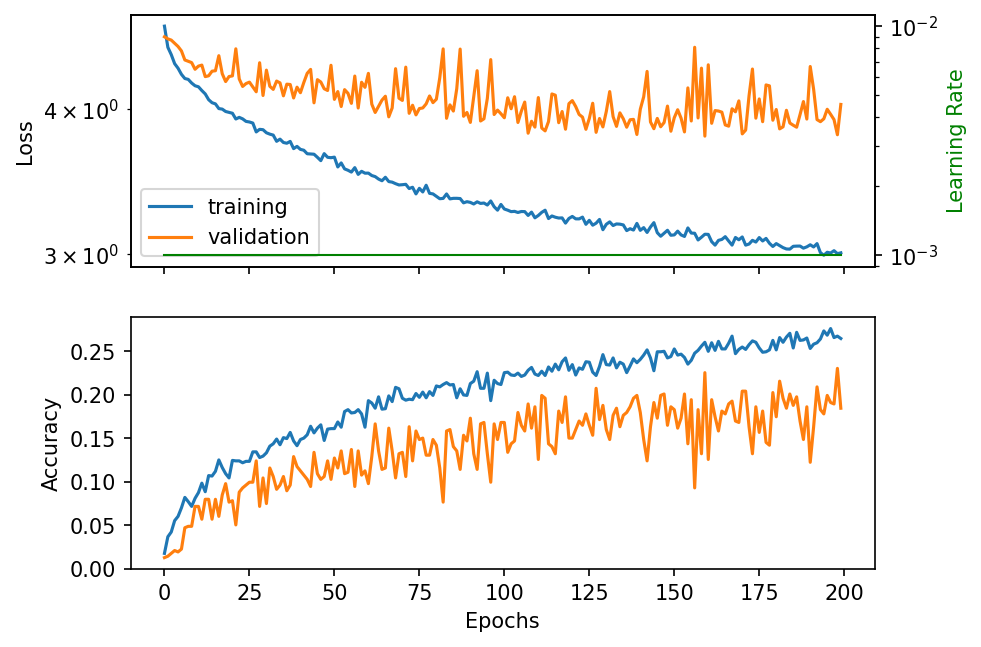

20/20 [==============================] - 1s 22ms/step - loss: 3.9625 - sparse_categorical_accuracy: 0.2059
Test loss: 3.962491750717163
Test accuracy: 0.20588235557079315


In [ ]:
from utils import plot_history

plot_history(model_2_conv_history)
loss, accuracy = model_2_conv.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

#History for Model with 3 Convolution Blocks and Augmentation Off.

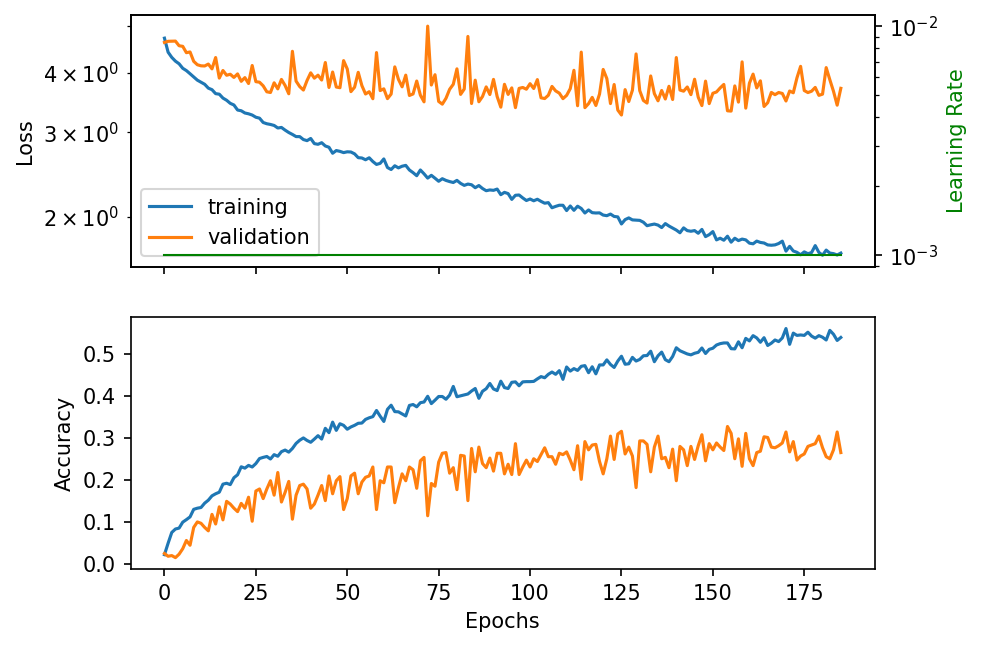

20/20 [==============================] - 0s 12ms/step - loss: 3.7035 - sparse_categorical_accuracy: 0.2958
Test loss: 3.7035434246063232
Test accuracy: 0.2957516312599182


In [ ]:
plot_history(model_3_conv_history)
loss, accuracy = model_3_conv.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

#History for Model 4 Convolution Blocks and Augmentation Off.

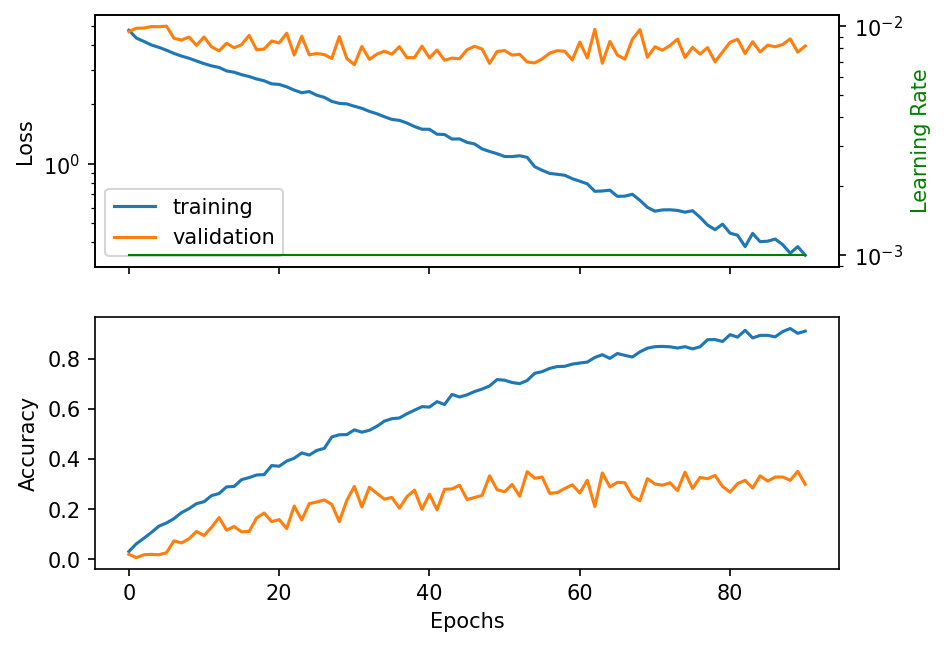

20/20 [==============================] - 0s 13ms/step - loss: 3.7419 - sparse_categorical_accuracy: 0.3350
Test loss: 3.7419190406799316
Test accuracy: 0.33496731519699097


In [ ]:
plot_history(model_4_conv_history)
loss, accuracy = model_4_conv.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

##Discussion:
###`Although, none of the models are generalizing well to the validation dataset, we can consider the model with 4 convolutional blocks as the best performing even though its overfitting because it still has the capacity to learn more, with having over 90% accuracy on the training set and best accuracy on the test set in comparison to the other models. In fairness to the model with 4 convolution blocks, the other models are neither doing good on the training set nor the validation set and they also perform poorly on the test set.`



###Re-initializing model with 4 conv blocks as best_model and turning augmentation on

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 128, 128, 3)         0         
                                                                 
 random_rotation (RandomRot  (32, 128, 128, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (32, 128, 128, 3)         0         
                                                                 
 random_contrast (RandomCon  (32, 128, 128, 3)         0         
 trast)                                                    

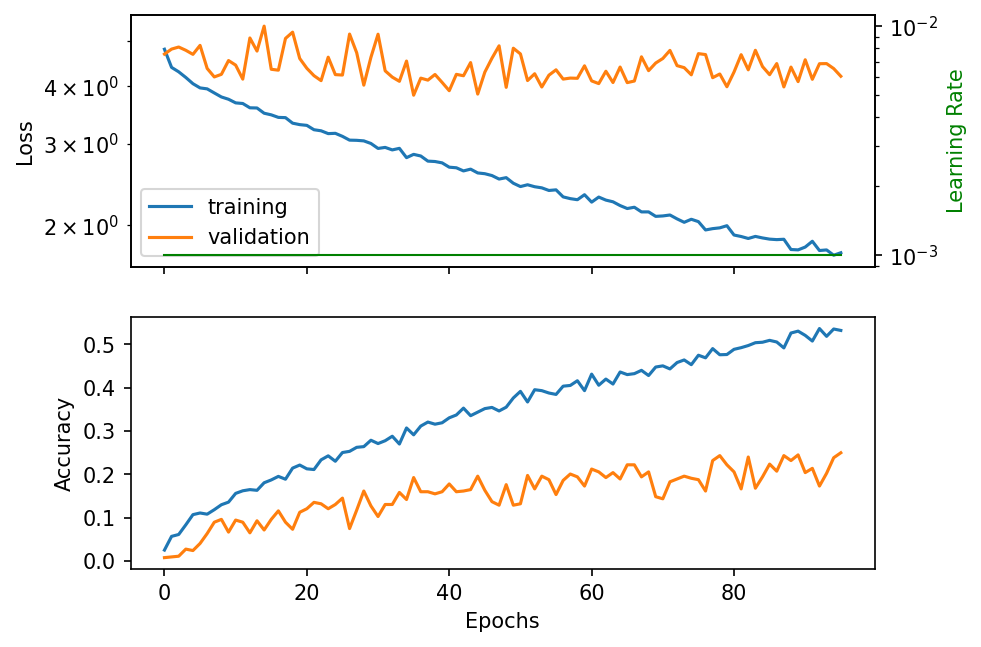

In [20]:
"""
Re-initializing model with 4 conv blocks as best_model and turning augmentation on
"""
best_model, best_model_history = train_model(train = batched_train,
                                           validation = batched_val,
                                           augment = True, num_filters = 32, num_blocks = 4)
plot_history(best_model_history)

###The best performing model with augmentation on is overfitting on the training dataset, also the accuracy dropped with augmentation turned on.
* Possible Reasons:
* Upon visualizing the dataset seems to have some kind augmentation already done on it, which can affect the ability of generalizing on the validation dataset
* Adding another pipeline of augmenation on top of that just makes it more complex for the model to learn the significant features, hence the drop in training accuracy from over 80% to approximately a little more than 50%.

#3.2 - Filter Size
###Create the subsection "3.2- Filter Size". Disable the augmentation again and use num_filters = 32 and num_blocks = 3 for all models. For filter sizes of (3x3, 5x5, 7x7), train your model using your train_model() function. For each model, use utils.plot_history() to plot the training and validation history and evaluate the model on the test data.

In [ ]:
model_3_3, model_3_3_history = None, None
model_5_5, model_5_5_history = None, None
model_7_7, model_7_7_history = None, None

filter_sizes = [3, 5, 7]
num_blocks = 3
for size in filter_sizes:
  if size == 3:
    print(f"Training with {num_blocks} convolutional blocks")
    model_3_3, model_3_3_history = train_model(train = batched_train,
                                            validation = batched_val,
                                            augment = False, num_filters = 32, num_blocks = num_blocks, size_filter = size)
  if size == 5:
    print(f"Training with {num_blocks} convolutional blocks")
    model_5_5, model_5_5_history = train_model(train = batched_train,
                                            validation = batched_val,
                                            augment = False, num_filters = 32, num_blocks = num_blocks, size_filter = size)

  if size == 7:
    print(f"Training with {num_blocks} convolutional blocks")
    model_7_7, model_7_7_history = train_model(train = batched_train,
                                            validation = batched_val,
                                            augment = False, num_filters = 32, num_blocks = num_blocks, size_filter = size)

Training with 3 convolutional blocks
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(32, 128, 128, 3)]       0         
                                                                 
 rescaling_16 (Rescaling)    (32, 128, 128, 3)         0         
                                                                 
 conv2d_50 (Conv2D)          (32, 126, 126, 32)        896       
                                                                 
 batch_normalization_50 (Ba  (32, 126, 126, 32)        128       
 tchNormalization)                                               
                                                                 
 re_lu_50 (ReLU)             (32, 126, 126, 32)        0         
                                                                 
 max_pooling2d_50 (MaxPooli  (32, 63, 63, 32)          0         
 ng2D)               

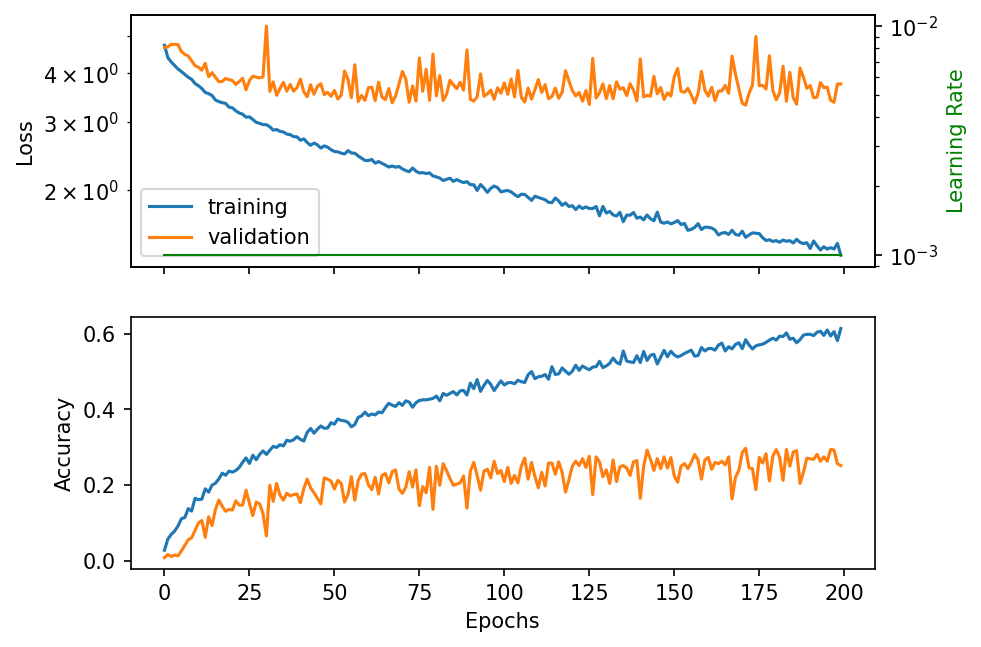

20/20 [==============================] - 0s 12ms/step - loss: 3.6227 - sparse_categorical_accuracy: 0.3105
Test loss: 3.622725009918213
Test accuracy: 0.3104575276374817


In [ ]:
plot_history(model_3_3_history)
loss, accuracy = model_3_3.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

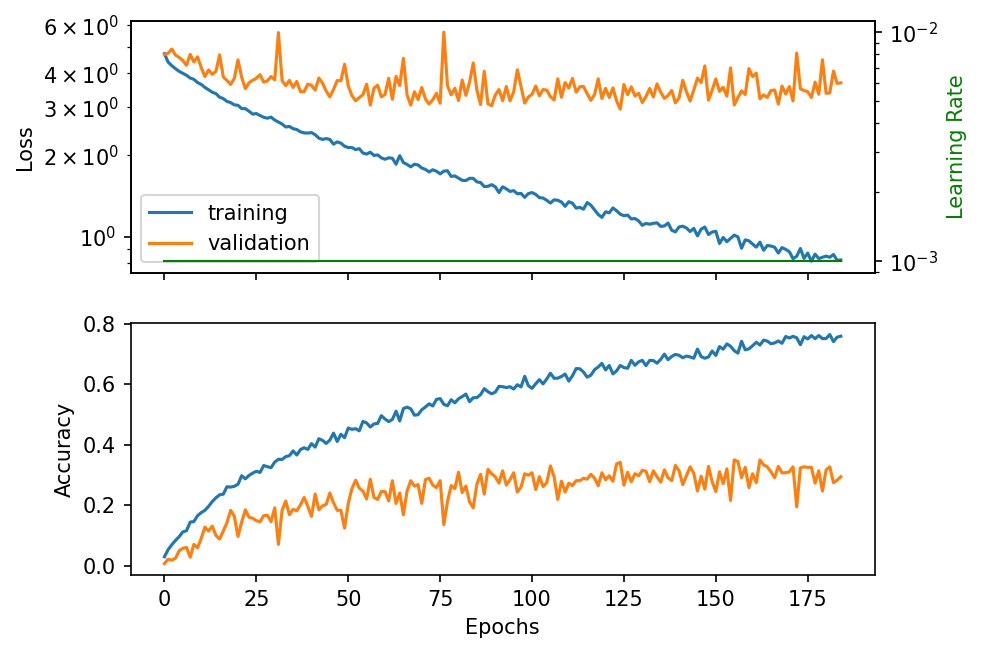

20/20 [==============================] - 0s 12ms/step - loss: 3.7890 - sparse_categorical_accuracy: 0.3415
Test loss: 3.7890162467956543
Test accuracy: 0.3415032625198364


In [ ]:
plot_history(model_5_5_history)
loss, accuracy = model_5_5.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

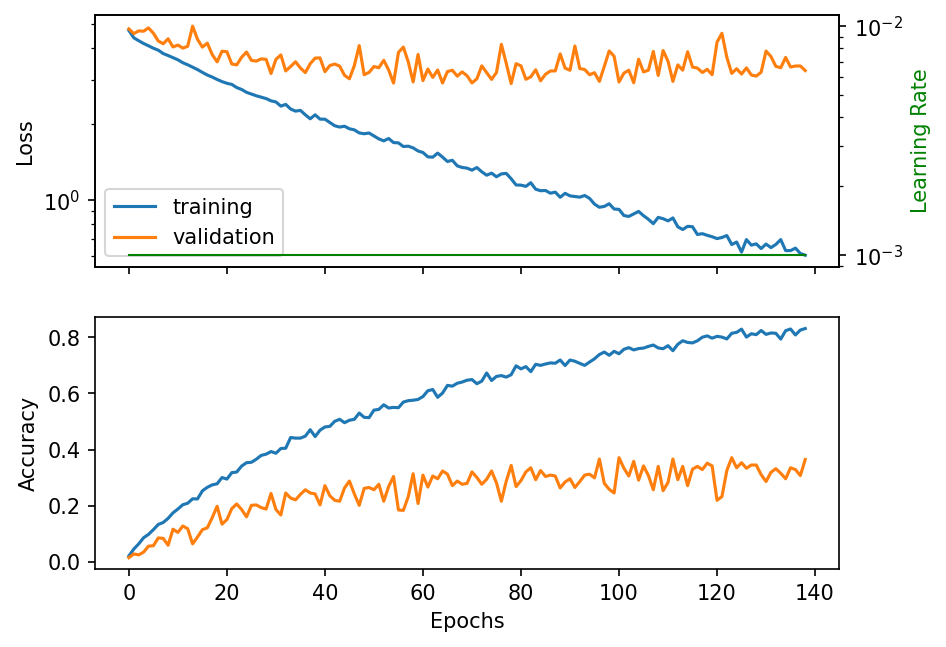

20/20 [==============================] - 0s 14ms/step - loss: 3.2349 - sparse_categorical_accuracy: 0.3578
Test loss: 3.2349395751953125
Test accuracy: 0.3578431308269501


In [ ]:
plot_history(model_7_7_history)
loss, accuracy = model_7_7.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

# 3.3: Results and Discussion


| No. Blocks | Filter Size | No. Params | Train Acc | Val Acc  | Test Acc |
|------------|-------------|------------|-----------|----------|----------|
| 3          | 3x3         |  107302    |   61.3%   |  25.16%  |  ~31%    |
| 3          | 5x5         |  272678    |   75.93%  |  29.41%  |  ~34%    |
| 3          | 7x7         |  520742    |   82.12%  |  36.44%  |  ~35%    |

###Discussion:
####From the table we can conclude that the increase in filter size improves the training accuracy and but ever so slightly increases the test accuracy as well. Number of parameters are also doubles with respect to the increase in filters.


* The general takeaway is the model does not generalize well on the validation set even with added complexity to the convolutional blocks alongside data regularization techniques like data augmentation, the improvement is relatively significant on the training dataset and respectively on the validation dataset in the context of just comparison between the metrics.


# Task 4: Fine-Tuning

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def build_model(input_shape, trainable = False, lr = 1e-3):

  # Initialize the pre-trained model
  pre_trained_model = EfficientNetB0(
      input_shape=input_shape,
      weights='imagenet',
      include_top=False
  )
  # Freezing the trainable parameters of EfficientNet
  pre_trained_model.trainable = trainable
  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  # Forward through pre-trained model
  x = pre_trained_model(input_img)

  # Add global maxpooling layer on output of pre-trained model
  x = layers.GlobalMaxPooling2D()(x)

  # Add a final layer for classification
  output = layers.Dense(len(class_labels), activation='softmax')(x)


  # Define the model
  model = Model(input_img, output)

  # Compile Model
  model.compile(
  optimizer=optimizers.Adam(learning_rate = lr),
  loss=losses.SparseCategoricalCrossentropy(),
  metrics=[
      metrics.SparseCategoricalAccuracy(),
  ],
  )

  print(model.summary())

  return model

In [ ]:
model = build_model((128, 128, 3))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_8 (Dense)             (None, 102)               130662    
                                                                 
Total params: 4180233 (15.95 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________
None


Epoch 1/5
58/58 - 66s - loss: 3.4659 - sparse_categorical_accuracy: 0.3627 - val_loss: 1.1456 - val_sparse_categorical_accuracy: 0.7059 - 66s/epoch - 1s/step
Epoch 2/5
58/58 - 51s - loss: 0.4633 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.8263 - val_sparse_categorical_accuracy: 0.7859 - 51s/epoch - 885ms/step
Epoch 3/5
58/58 - 50s - loss: 0.1647 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.6677 - val_sparse_categorical_accuracy: 0.8186 - 50s/epoch - 867ms/step
Epoch 4/5
58/58 - 48s - loss: 0.0818 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.8301 - 48s/epoch - 820ms/step
Epoch 5/5
58/58 - 48s - loss: 0.0510 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.6182 - val_sparse_categorical_accuracy: 0.8350 - 48s/epoch - 821ms/step


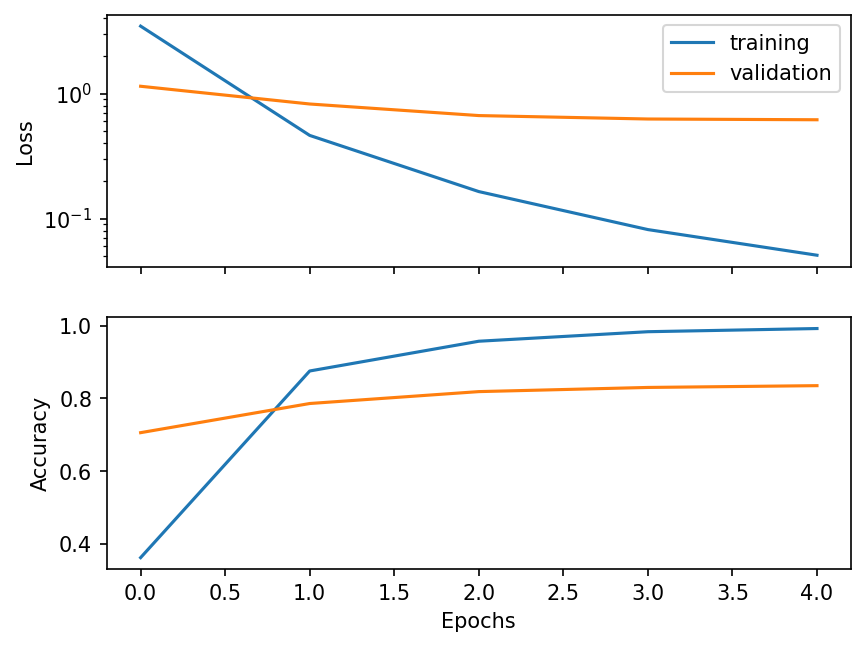

In [ ]:
history = model.fit(
    batched_train,
    validation_data=batched_val,
    epochs=5,
    verbose=2
)

utils.plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 11s 556ms/step - loss: 0.7603 - sparse_categorical_accuracy: 0.7990
Test loss: 0.7603294253349304
Test accuracy: 0.7990196347236633


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_4 (Dense)             (None, 102)               130662    
                                                                 
Total params: 4180233 (15.95 MB)
Trainable params: 4138210 (15.79 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________
None
Epoch 1/50

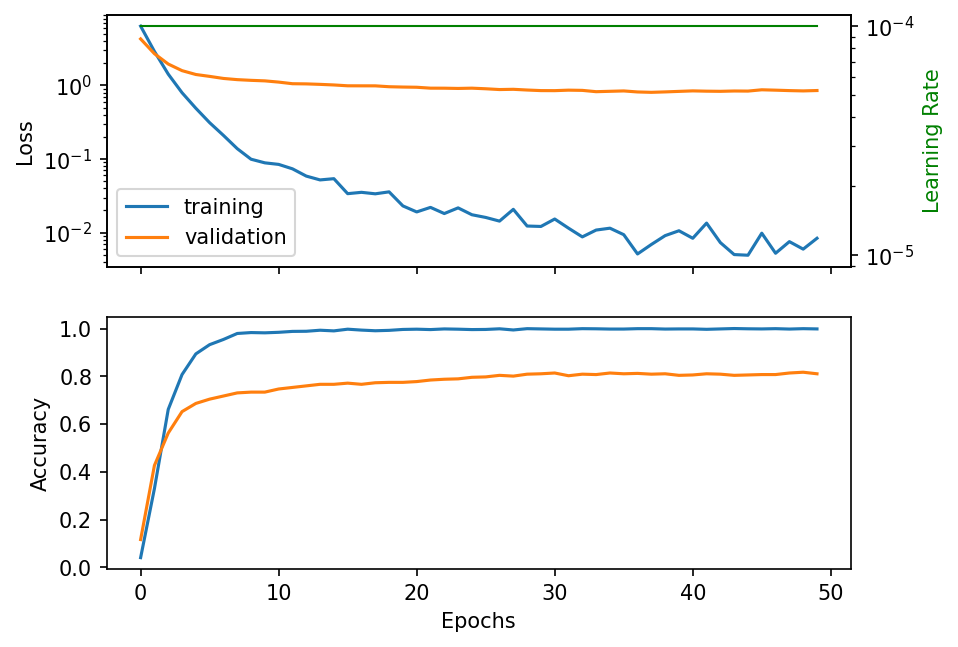

In [ ]:
# Initialize pre_trained model with trainable parameters set to True
unfreezed_model = build_model(input_shape = (128, 128, 3), trainable=True, lr = 1e-4)

# use the ReduceLROnPlateau callback to reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.001,)

#Stop the training if there is no improvement in the validation loss for 15 epochs                                )
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
)

history_unfreezed = unfreezed_model.fit(
    batched_train,
    validation_data=batched_val,
    epochs=50,
    verbose=2,
    callbacks = [reduce_lr, early_stop]
)

utils.plot_history(history_unfreezed)

In [ ]:
loss, accuracy = unfreezed_model.evaluate(batched_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 33ms/step - loss: 0.7495 - sparse_categorical_accuracy: 0.8350
Test loss: 0.7495490908622742
Test accuracy: 0.834967315196991


#4: Results and Discussion

* `Using Transfer Learning`, it is observed that training the model for 5 epochs the training loss immediately decreases in the 2nd epoch,
mainly because we have freezed the learned parameters in EfficientNet on the ImageNet Dataset, and we are just leveraging that learning
and applying it on our problem. Essentially, there is nothing much to learn as most of the learnable parameters in the Caltech101 dataset
are already seen in the ImageNet dataset which is relatively a larger dataset than Caltech101.

* `Results on the training and validation dataset: Training := loss: 0.0510 - training_accuracy: 0.9918; Validation := val_loss: 0.6182 - val_accuracy: 0.8350`
* `Results on the test set: Test loss: 0.7603294253349304; Test accuracy: 0.7990196347236633`

===================================================================================================================
* `Fine-tuning` the EfficientNet means we are using the architecture of the EfficientNet NN and training it from scratch on our dataset which is Caltech101.
Having tried three different learning rates (1e-3, 1e-4, and 1e-5), I ended up going with the learning rate set at 1e-4, because the loss curve was converging steadily
on it, learning rate with 1e-3 was too big of a step and although it seemed like the training and validation loss was decreasing in certain epochs the validation loss
was increasing or overshooting justifying that the model is having difficulty finding the local minima on the validation dataset, with learning rate set to 1e-5,
the training and validation loss were decreasing but since the learning rate was relatively small and the number of epochs were set to 50, the desired validation
loss and accuracy was not good in comparison to loss & accuracy of models with learning rates -> 1e-3 and 1e-4

* `Results on the training and validation dataset: Training := loss: 0.0084 - training_accuracy: 0.9984 - val_loss: 0.8543 - val_accuracy: 0.8105 - lr: 1.0000e-04`
* `Results on the test set: Test loss: 0.7495490908622742; Test accuracy: 0.834967315196991`

####`As external help, I mostly referred to the keras documentation for understanding methods/functions such as callbacks like ReduceLR and EarlyStopping. As for understanding the CaltechDataset101 and why the convolutional blocks were behaving a certain way, I refered to ChatGPT with prompts like: Explain the significance of bias terms in covolutional layers, describe the structure of Caltech101 dataset and dicuss the categories/classes in it.`